## ЙОУ!
## Сегодня снова речь пойдёт о найстройке гиперпараметров

#### Сегодня вебинар №2 - Самая жара, здесь разберём основные подходы к подбору оптимальных гиперпараметров (1,5 часа):
- "Кривых обучения" - дальше он нам пригодится в deep learning-е
- как делать оптимизацию по сетке?
- как мы проводим оценку моделей при фиксе гиперпараметров с помощью кросс-валидации?
- что такое логарифмическая сетка, и как её использовать?
- что выбрать: GridSearchCV или RandomizeSearchCV
- какие интервалы стоит выбирать, чтобы не ждать примерно вечность?
- распараллеливание подбора

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt

Сегодня наша задача как раз состоит в том, чтобы с помощью случайного леса на основе метеорологических данных предсказать, будет ли дождь на следующий день. Данные собраны в разных регионах Австралии за 2013-2017 годы.

In [2]:
weather = pd.read_csv('/Users/kirillsokolov/Desktop/MY_DATA/karpov.courses/Karpov.Courses/randomforest/AUS_train_dataset.csv')

medians_dict = {}

for col in weather.columns.drop('RainTomorrow'):
    medians_dict[col] = weather[col].median()

for col in weather.columns.drop('RainTomorrow'):
    weather[col] = weather[col].fillna(medians_dict[col])

y_train = weather.RainTomorrow
X_train = weather.drop('RainTomorrow', 1)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_91387/3122520859.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = weather.drop('RainTomorrow', 1)


In [3]:
weather

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,12.3,25.7,10.8,9.8,12.6,22.0,6.0,11.0,38.0,34.0,1018.4,1014.5,1.0,1.0,21.0,24.4,0
1,11.5,21.5,0.0,5.2,8.6,41.0,15.0,19.0,71.0,56.0,1018.5,1017.0,5.0,5.0,16.0,18.4,0
2,1.6,9.0,0.8,5.2,8.6,31.0,17.0,20.0,100.0,100.0,1024.4,1024.9,7.0,7.0,5.0,8.3,0
3,7.6,14.2,4.6,5.2,8.6,37.0,20.0,20.0,85.0,68.0,1017.9,1017.9,8.0,8.0,8.7,12.8,0
4,15.4,24.7,0.0,5.2,8.6,37.0,15.0,19.0,60.0,45.0,1010.3,1009.6,5.0,5.0,21.6,23.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52752,19.7,25.7,29.6,5.2,8.6,41.0,28.0,6.0,95.0,70.0,1016.4,1016.2,8.0,5.0,20.0,24.3,1
52753,11.2,26.5,0.0,4.0,8.9,33.0,13.0,20.0,45.0,23.0,1028.5,1024.4,6.0,4.0,21.3,25.9,0
52754,8.7,28.0,0.0,5.6,8.6,33.0,17.0,9.0,48.0,51.0,1017.9,1013.3,0.0,5.0,17.0,21.6,0
52755,1.0,16.7,0.2,5.2,8.6,44.0,0.0,17.0,100.0,54.0,1024.7,1020.0,8.0,5.0,4.3,16.4,0


### Начнём с простого: как правильно оценивать качество модели?
### Ответ: с помощью кросс-валидации!

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png'>

Для кросс-валидации существует ряд уже готовых функций в sklearn:

    - sklearn.model_selection.cross_val_score
    - sklearn.model_selection.cross_val_predict

In [4]:
rf_no_grid = RandomForestClassifier(    
    n_estimators=50,
    max_depth=6,
    max_features=3,
    class_weight='balanced'
)

In [9]:
%%time
cross_val_result = cross_val_score(rf_no_grid, X_train, y_train, cv=10, scoring='roc_auc')

CPU times: user 10.6 s, sys: 65.3 ms, total: 10.7 s
Wall time: 10.7 s


In [10]:
cross_val_result

array([0.85352532, 0.85713595, 0.85640967, 0.84837844, 0.85351246,
       0.84889596, 0.84867391, 0.84776624, 0.85973784, 0.85066491])

In [11]:
cross_val_result.mean()

0.8524700711268377

In [12]:
cross_val_result.std()

0.004020232476248245

In [14]:
%%time
cross_val_predict(rf_no_grid, X_train, y_train, cv=3)

CPU times: user 2.63 s, sys: 24 ms, total: 2.65 s
Wall time: 2.66 s


array([0, 0, 1, ..., 0, 0, 0])

In [30]:
%%time
y_pred = cross_val_predict(rf_no_grid, X_train, y_train, cv=10, method='predict')
y_pred_proba = cross_val_predict(rf_no_grid, X_train, y_train, cv=10, method='predict_proba')

CPU times: user 21.5 s, sys: 149 ms, total: 21.7 s
Wall time: 21.7 s


In [32]:
roc_auc_score(y_train, y_pred)

0.7690394037582615

In [33]:
roc_auc_score(y_train, y_pred_proba[:, 1])

0.8519719765140945

### Самый простой способ найти гиперпараметр - кривые обучения

In [40]:
curve = []
curve_train = []
depths = [i for i in range(5, 30, 4)]

In [41]:
depths

[5, 9, 13, 17, 21, 25, 29]

In [42]:
%%time

for i in depths:
    rf_learning_curve = RandomForestClassifier(    
        n_estimators=100,
        max_depth=i,
        max_features=3,
        class_weight='balanced'
    )
    
    curve.append(
        cross_val_score(
            rf_learning_curve, 
            X_train, 
            y_train, 
            cv=3, 
            scoring='roc_auc'
        ).mean()
    )
    
    rf_learning_curve.fit(X_train, y_train)
    curve_train.append(
        roc_auc_score(y_train, rf_learning_curve.predict_proba(X_train)[:, 1])
    )
    

CPU times: user 1min 47s, sys: 600 ms, total: 1min 47s
Wall time: 1min 47s


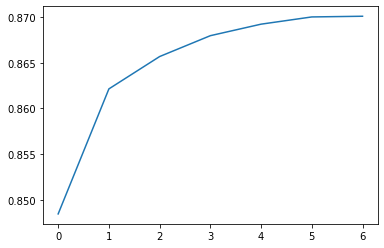

In [63]:
plt.plot(curve)
plt.plot(curve_train)

### Более общий подход к оценке параметров - это настройка по сетке. И тут мы разберём несколько нюансов.

In [64]:
new_df = weather.sample(5000).reset_index(drop=True)

y_train = new_df.RainTomorrow
X_train = new_df.drop('RainTomorrow', 1)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_91387/143387447.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = new_df.drop('RainTomorrow', 1)


1: [80, 320, 1280] -> 1280

2: [760, 1280, 2560] -> 2560

3: [2000, 2560, 5120] -> 5120

In [ ]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_features': [3, 4, 5]
}

In [110]:
# Логарифмическая сетка параметров

parameters = {
    'n_estimators': [80, 240, 540],
    'max_depth': [8, 16],
    'max_features': [4]
}

In [111]:
rf = RandomForestClassifier()

In [112]:
clf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=8, n_jobs=-1)

In [113]:
%%time
clf.fit(X_train, y_train)

CPU times: user 7.77 s, sys: 336 ms, total: 8.11 s
Wall time: 47.7 s


GridSearchCV(cv=8, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [6, 12, 24], 'max_features': [4],
                         'n_estimators': [20, 40, 80, 160, 320, 640, 1280]},
             scoring='roc_auc')

In [114]:
clf.best_score_

0.854604748579336

In [115]:
clf.best_params_

{'max_depth': 12, 'max_features': 4, 'n_estimators': 1280}